## importy

In [1]:
from gensim.utils import tokenize
import numpy as np
import torch
from tqdm.notebook import tqdm

/media/kuba/ssdsam/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

In [3]:
print('Using {} device'.format(device))

Using cuda device


In [4]:
device

device(type='cuda')

## przygotowanie zbiorów

In [5]:
pan_tadeusz_path_train= '/home/kuba/Syncthing/przedmioty/2020-02/ISI/zajecia9_ngramowy_model_jDDezykowy/pan-tadeusz-train.txt'

In [6]:
pan_tadeusz_path_valid= '/home/kuba/Syncthing/przedmioty/2020-02/ISI/zajecia9_ngramowy_model_jDDezykowy/pan-tadeusz-test.txt'

In [7]:
corpora_train = open(pan_tadeusz_path_train).read()

In [8]:
corpora_train_tokenized = list(tokenize(corpora_train,lowercase = True))

In [9]:
vocab_itos = sorted(set(corpora_train_tokenized))

In [10]:
len(vocab_itos)

16598

In [11]:
vocab_itos = vocab_itos[:15005]
vocab_itos[15001] = "<UNK>"
vocab_itos[15002] = "<BOS>"
vocab_itos[15003] = "<EOS>"
vocab_itos[15004] = "<PAD>"

In [12]:
len(vocab_itos)

15005

In [13]:
vocab_stoi = dict()
for i, token in enumerate(vocab_itos):
    vocab_stoi[token] = i

In [14]:
NGRAMS = 5

In [15]:
def get_token_id(dataset):
    token_ids = [vocab_stoi['<PAD>']] * (NGRAMS-1) + [vocab_stoi['<BOS>']]
    for token in dataset:
        try:
            token_ids.append(vocab_stoi[token])
        except KeyError:
            token_ids.append(vocab_stoi['<UNK>'])
    token_ids.append(vocab_stoi['<EOS>'])
    return token_ids

In [16]:
train_ids = get_token_id(corpora_train_tokenized)

In [17]:
train_ids[:30]

[15004,
 15004,
 15004,
 15004,
 15002,
 7,
 5002,
 7247,
 11955,
 1432,
 7018,
 14739,
 5506,
 4696,
 4276,
 7505,
 2642,
 8477,
 7259,
 10870,
 10530,
 7506,
 12968,
 7997,
 1911,
 12479,
 11129,
 13069,
 11797,
 5819]

In [18]:
def get_samples(dataset):
    samples = []
    for i in range(len(dataset)-NGRAMS):
        samples.append(dataset[i:i+NGRAMS])
    return samples

In [19]:
train_ids = get_samples(train_ids)

In [20]:
train_ids = torch.tensor(train_ids, device = device)

In [21]:
train_ids[:30]

tensor([[15004, 15004, 15004, 15004, 15002],
        [15004, 15004, 15004, 15002,     7],
        [15004, 15004, 15002,     7,  5002],
        [15004, 15002,     7,  5002,  7247],
        [15002,     7,  5002,  7247, 11955],
        [    7,  5002,  7247, 11955,  1432],
        [ 5002,  7247, 11955,  1432,  7018],
        [ 7247, 11955,  1432,  7018, 14739],
        [11955,  1432,  7018, 14739,  5506],
        [ 1432,  7018, 14739,  5506,  4696],
        [ 7018, 14739,  5506,  4696,  4276],
        [14739,  5506,  4696,  4276,  7505],
        [ 5506,  4696,  4276,  7505,  2642],
        [ 4696,  4276,  7505,  2642,  8477],
        [ 4276,  7505,  2642,  8477,  7259],
        [ 7505,  2642,  8477,  7259, 10870],
        [ 2642,  8477,  7259, 10870, 10530],
        [ 8477,  7259, 10870, 10530,  7506],
        [ 7259, 10870, 10530,  7506, 12968],
        [10870, 10530,  7506, 12968,  7997],
        [10530,  7506, 12968,  7997,  1911],
        [ 7506, 12968,  7997,  1911, 12479],
        [1

In [22]:
train_ids.shape

torch.Size([57022, 5])

In [23]:
corpora_valid = open(pan_tadeusz_path_valid).read()

In [24]:
corpora_valid_tokenized = list(tokenize(corpora_valid,lowercase = True))

In [25]:
valid_ids = get_token_id(corpora_valid_tokenized)

In [26]:
valid_ids = torch.tensor(get_samples(valid_ids), dtype = torch.long, device = device)

## model

In [27]:
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [28]:
class LSTM(torch.nn.Module):

    def __init__(self):
        super(LSTM, self).__init__()
        self.emb = torch.nn.Embedding(len(vocab_itos),100)
        self.rec = torch.nn.LSTM(100, 256, 1, batch_first = True)
        self.fc1 = torch.nn.Linear( 256 ,len(vocab_itos))
        #self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        emb = self.emb(x)
        #emb = self.dropout(emb)
        output, (h_n, c_n) = self.rec(emb)
        hidden = h_n.squeeze(0)
        out = self.fc1(hidden)
        #out = self.dropout(out)
        return out

In [29]:
lm = LSTM().to(device)

In [30]:
criterion = torch.nn.CrossEntropyLoss()

In [31]:
optimizer = torch.optim.Adam(lm.parameters(),lr=0.0001)

In [32]:
BATCH_SIZE = 128
EPOCHS = 15

In [33]:
def get_ppl(dataset_ids):
    lm.eval()

    batches = 0
    loss_sum =0
    acc_score = 0

    for i in range(0, len(dataset_ids)-BATCH_SIZE+1, BATCH_SIZE):
        X = dataset_ids[i:i+BATCH_SIZE,:NGRAMS-1]
        Y = dataset_ids[i:i+BATCH_SIZE,NGRAMS-1]
        predictions = lm(X)
        
        # equally distributted
        # predictions = torch.zeros_like(predictions)
        
        loss = criterion(predictions,Y)

        loss_sum += loss.item()
        batches += 1

    return np.exp(loss_sum / batches)

In [34]:
history_ppl_train  = []
history_ppl_valid  = []
for epoch in range(EPOCHS):
    
    batches = 0
    loss_sum =0
    acc_score = 0
    lm.train()
    #for i in range(0, len(train_ids)-BATCH_SIZE+1, BATCH_SIZE):
    for i in tqdm(range(0, len(train_ids)-BATCH_SIZE+1, BATCH_SIZE)):
        X = train_ids[i:i+BATCH_SIZE,:NGRAMS-1]
        Y = train_ids[i:i+BATCH_SIZE,NGRAMS-1]
        predictions = lm(X)
        loss = criterion(predictions,Y)
    
    
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        batches += 1
        
    ppl_train = get_ppl(train_ids)
    ppl_valid = get_ppl(valid_ids)
    
    history_ppl_train.append(ppl_train)
    history_ppl_valid.append(ppl_valid)
    
    print('epoch: ', epoch)
    print('train ppl: ', ppl_train)
    print('valid ppl: ', ppl_valid)
    print()


epoch:  0
train ppl:  2296.6914856482526
valid ppl:  528.9542436139727




epoch:  1
train ppl:  2093.302103954666
valid ppl:  514.4726844027333




epoch:  2
train ppl:  2014.09679023559
valid ppl:  510.12146471773366




epoch:  3
train ppl:  1939.0594855086504
valid ppl:  509.1060151440451




epoch:  4
train ppl:  1854.4566511885196
valid ppl:  510.02244291272973




epoch:  5
train ppl:  1755.030202547313
valid ppl:  508.494174178397




epoch:  6
train ppl:  1646.180912657662
valid ppl:  506.06383737670035




epoch:  7
train ppl:  1533.0501876139222
valid ppl:  504.08067276707567




epoch:  8
train ppl:  1420.680717507558
valid ppl:  502.6906095632547




epoch:  9
train ppl:  1311.1083504083306
valid ppl:  503.5230045363773




epoch:  10
train ppl:  1203.498635587493
valid ppl:  505.7599916969862




epoch:  11
train ppl:  1100.0681613054269
valid ppl:  507.6071195979723




epoch:  12
train ppl:  1003.217414775517
valid ppl:  510.07952767103245




epoch:  13
train ppl:  912.2987798296267
valid ppl:  512.8275727599236




epoch:  14
train ppl:  826.911431868259
valid ppl:  516.1525759633064



## parametry modelu

In [35]:
list(lm.parameters())

[Parameter containing:
 tensor([[ 0.4949, -1.2472, -0.7167,  ..., -0.0801, -2.1905,  0.9790],
         [ 0.2070,  1.7394,  0.8255,  ..., -0.5796, -0.3776,  0.8831],
         [-1.4559,  1.1073, -0.4904,  ..., -1.2919, -2.2661, -0.5476],
         ...,
         [-0.3706,  0.2133,  0.0484,  ..., -0.5792, -0.5769, -0.6941],
         [ 0.5502, -0.1212, -2.0879,  ...,  0.6764, -0.5961, -0.6282],
         [ 0.8362,  0.2193, -0.0807,  ...,  2.7741, -0.2589,  0.3310]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0252, -0.0744,  0.0817,  ..., -0.0559,  0.0896,  0.0208],
         [ 0.0423,  0.0329, -0.0610,  ..., -0.0009,  0.0169, -0.0361],
         [ 0.0507, -0.0838,  0.0520,  ...,  0.0395,  0.0067,  0.0173],
         ...,
         [ 0.0669,  0.0430, -0.0306,  ...,  0.0096,  0.0619, -0.0992],
         [-0.0153, -0.0888,  0.0580,  ..., -0.0433,  0.0399, -0.0494],
         [-0.0067, -0.0053, -0.0242,  ...,  0.0017, -0.0306, -0.0972]],
        device='cuda:0', r

### krzywe uczenia

In [36]:
history_ppl_valid

[528.9542436139727,
 514.4726844027333,
 510.12146471773366,
 509.1060151440451,
 510.02244291272973,
 508.494174178397,
 506.06383737670035,
 504.08067276707567,
 502.6906095632547,
 503.5230045363773,
 505.7599916969862,
 507.6071195979723,
 510.07952767103245,
 512.8275727599236,
 516.1525759633064]

In [37]:
import matplotlib.pyplot as plt

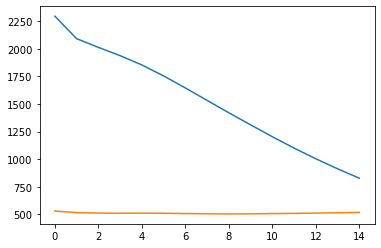

In [38]:
plt.plot(np.arange(len(history_ppl_train)), history_ppl_train, history_ppl_valid)

## Inferencja

In [39]:
'Gości innych nie widział oprócz spółleśników'

'Gości innych nie widział oprócz spółleśników'

In [40]:
tokenized = list(tokenize('Gości innych nie widział oprócz spółleśników',lowercase = True))

In [41]:
#tokenized = tokenized[-NGRAMS  :-1 ]

In [42]:
tokenized

['gości', 'innych', 'nie', 'widział', 'oprócz', 'spółleśników']

In [43]:
ids = []
for word in tokenized:
    if word in vocab_stoi:
        ids.append(vocab_stoi[word])
    else:
        ids.append(vocab_stoi['<UNK>'])

In [44]:
ids

[2671, 3168, 5873, 13240, 6938, 15001]

In [45]:
lm.eval()

LSTM(
  (emb): Embedding(15005, 100)
  (rec): LSTM(100, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=15005, bias=True)
)

In [46]:
ids = torch.tensor(ids, dtype = torch.long, device = device)

In [47]:
ids

tensor([ 2671,  3168,  5873, 13240,  6938, 15001], device='cuda:0')

In [48]:
preds= lm(ids.unsqueeze(0))

In [49]:
torch.argmax(torch.softmax(preds,1),1).item()

15001

In [50]:
torch.max(torch.softmax(preds,1),1)

torch.return_types.max(
values=tensor([0.1419], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([15001], device='cuda:0'))

In [51]:
vocab_itos[torch.argmax(torch.softmax(preds,1),1).item()]

'<UNK>'

## ZADANIE: GENEROWANIE TEKSTU

Napisać funkcję generującą tekst, która dla podanego fragmentu generuje tekst.
Generowanie tekstu ma wyglądać następująco: Z 10 najbardziej prawodpodobnych tokenów należy wylosować jeden, ala ma to byc token inny niż specjalny (UNK, BOS, EOS, PAD). 

wygenerować tekst o długości 30 tokenów